# Init

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt

---
# Data

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.describe()

,Open Price,Close Price,High Price,Low Price,Volume
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,1656.142686,1656.767562,1664.427054,1647.425128,2.948755e+09
std,485.292193,485.226120,484.808706,485.576116,1.351675e+09
min,679.280000,676.530000,695.270000,666.790000,5.181584e+08
25%,1238.602500,1239.337500,1246.695000,1227.587500,2.048980e+09
50%,1649.135000,1650.405000,1656.145000,1639.600000,2.506637e+09
75%,2070.300000,2071.190000,2079.507500,2058.757500,3.373334e+09
max,2692.710000,2690.160000,2694.970000,2685.920000,9.120100e+09


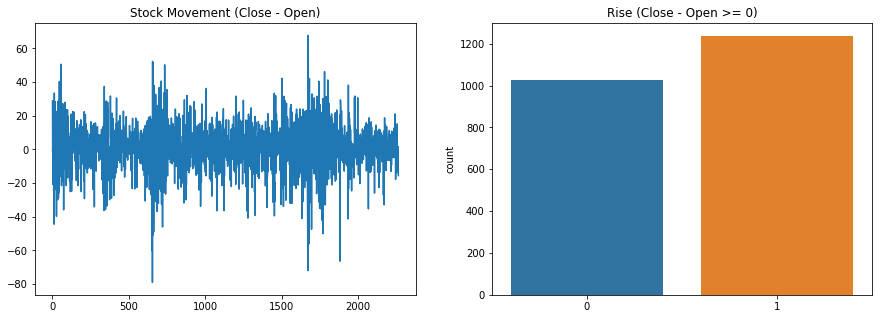

In [7]:
close_sub_open = train['Close Price'] - train['Open Price']

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Stock Movement (Close - Open)')
sns.lineplot(range(len(close_sub_open)), close_sub_open);
plt.subplot(122)
plt.title('Rise (Close - Open >= 0)')
sns.countplot(close_sub_open.apply(lambda x: 1 if x>=0 else 0));

plt.savefig('img/movement_rise.png');

---
# Preprocessing


In [8]:
def preprocess_df(df, prev_days=0):
    df = df.rename(lambda s: s.split(' ')[0], axis='columns')
    
    o, h, l, c = 'Open', 'High', 'Low', 'Close'
    df[o+'-'+h] = df[o] - df[h]
    df[o+'-'+l] = df[o] - df[l]
    if prev_days > 0:
        df[o+'-'+c] = df[o] - df[c]
    
    n = len(df)-prev_days
    
    y = ((df[c] - df[o]) >= 0).astype(int).shift(-prev_days).head(n)
    
    df = df.drop([o,h,l,c,'Volume', 'Date'], axis=1)

    if prev_days > 0:
        X = pd.concat(
            [df.shift(-i).add_prefix(f'{-prev_days+i}_') for i in range(prev_days)],
            axis=1,
        ).head(n)
    else:
        X = df
    
    return X, pd.Series(y, name='Rise', index=range(n))

In [9]:
def preprocess_dfs(train, test, prev_days=0):
    x_train, y_train = preprocess_df(train, prev_days=prev_days)
    x_test, y_test = preprocess_df(test, prev_days=prev_days)

    scaler = MinMaxScaler().fit(x_train.astype(float))

    x_train[:] = scaler.transform(x_train.astype(float))
    x_test[:] = scaler.transform(x_test.astype(float))
    
    return x_train, y_train, x_test, y_test

---
# Training/Testing

In [10]:
def get_accuracy(c):
    c.fit(x_train, y_train)
    train_acc = c.score(x_train, y_train)
    test_acc = c.score(x_test, y_test)
    return train_acc, test_acc

In [11]:
def train_test(x_train, y_train, x_test, y_test):
    hidden_units = 10
    l2 = 0.01
    learning_rate = 0.05
    epochs = 10
    batch_size = 16

    model = models.Sequential()

    model.add(layers.Dense(input_dim=len(x_train.columns),
                           units=hidden_units, 
                           activation='sigmoid'))

    model.add(layers.Dense(input_dim=hidden_units,
                           units=1,
                           activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])

    # train the parameters
    history = model.fit(x_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=0)

    # evaluate accuracy
    train_acc = model.evaluate(x_train, y_train, batch_size=batch_size)[1]
    test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)[1]

#     losses = history.history['loss']
#     plt.plot(range(len(losses)), losses);

    ret_mlp = (train_acc, test_acc)
    ret_svc = get_accuracy(SVC(gamma='auto'))
    ret_lr = get_accuracy(LogisticRegression(solver='lbfgs'))
    
    v_type = ['train', 'test']
    data = [
        [ret_mlp[0], v_type[0], 'MLP'],
        [ret_svc[0], v_type[0], 'SVC'],
        [ret_lr[0], v_type[0], 'Logistic Regression'],
        [ret_mlp[1], v_type[1], 'MLP'],
        [ret_svc[1], v_type[1], 'SVC'],
        [ret_lr[1], v_type[1], 'Logistic Regression']
    ]
    columns = ['value', 'type', 'model']
    return pd.DataFrame(data, columns=columns)


---

# Execution (varying range of input)

## Same day (Close Price excluded from input)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
252/252 [==============================] - 0s 51us/sample - loss: 0.4401 - acc: 0.8333


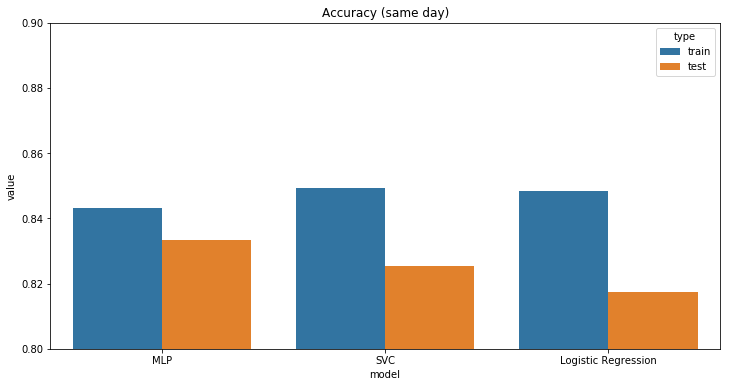

In [12]:
plt.figure(figsize=(12,6))
x_train, y_train, x_test, y_test = preprocess_dfs(train, test, prev_days=0)
sns.barplot(x='model', 
            y='value', 
            hue='type', 
            data=train_test(x_train, y_train, x_test, y_test))
plt.title('Accuracy (same day)');
plt.ylim(0.8,0.9);
plt.savefig('img/accuracy_same_day.png');

## Previous 1 day

251/251 [==============================] - 0s 52us/sample - loss: 0.6968 - acc: 0.4980


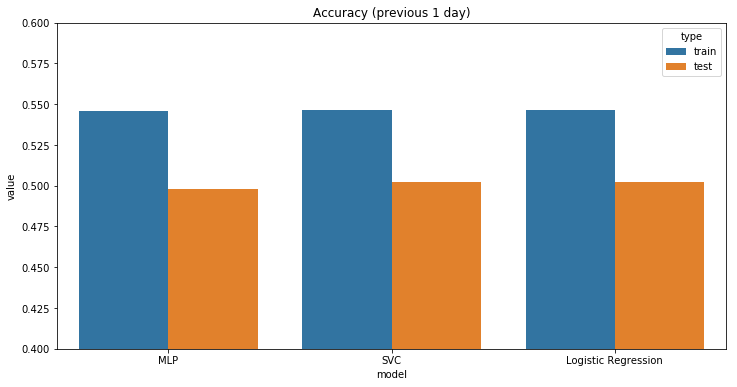

In [13]:
plt.figure(figsize=(12,6))
x_train, y_train, x_test, y_test = preprocess_dfs(train, test, prev_days=1)
sns.barplot(x='model', 
            y='value', 
            hue='type', 
            data=train_test(x_train, y_train, x_test, y_test))
plt.title('Accuracy (previous 1 day)');
plt.ylim(0.4,0.6);
plt.savefig('img/accuracy_prev_1_day.png');

## Previous 5 days

247/247 [==============================] - 0s 36us/sample - loss: 0.6952 - acc: 0.4939


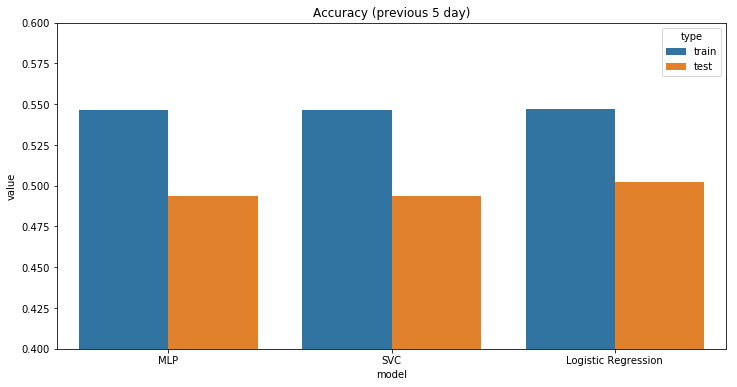

In [14]:
plt.figure(figsize=(12,6))
x_train, y_train, x_test, y_test = preprocess_dfs(train, test, prev_days=5)
sns.barplot(x='model', 
            y='value', 
            hue='type', 
            data=train_test(x_train, y_train, x_test, y_test))
plt.title('Accuracy (previous 5 day)');
plt.ylim(0.4,0.6);
plt.savefig('img/accuracy_prev_5_days.png');